In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import warnings
import datetime
warnings.filterwarnings("ignore")
from datetime import datetime, date


In [2]:
events = pd.read_csv("raw_data/events.csv")
category_tree = pd.read_csv("raw_data/category_tree.csv")
item_properties_1= pd.read_csv("raw_data/item_properties_part1.csv")
item_properties_2= pd.read_csv("raw_data/item_properties_part2.csv")
item_properties = pd.concat([item_properties_1, item_properties_2], ignore_index=True)
del item_properties_1, item_properties_2

timestamp          int64
visitorid          int64
event             object
itemid             int64
transactionid    float64
dtype: object

In [209]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [210]:
item_properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [211]:
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [212]:
print("Number of users: ",events["visitorid"].nunique())
print("Number of items: ",item_properties["itemid"].nunique())
print("Number of item properties: ",item_properties["property"].nunique())

Number of users:  1407580
Number of items:  417053
Number of item properties:  1104


In [213]:
events.shape[0]

2756101

In [38]:
#We cannot use transaction id, so we will drop it
events = events.drop(['transactionid'],axis=1)

In [39]:
events=events.drop_duplicates()
item_properties = item_properties.drop_duplicates()

In [40]:
events['timestamp']= events['timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))
item_properties['timestamp']= item_properties['timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))
print("start_time:",events['timestamp'].min())
print("End time", events['timestamp'].max())

start_time: 2015-05-02 20:00:04.384000
End time 2015-09-17 19:59:47.788000


In [41]:
cutoff_time = pd.to_datetime('2015-08-01')
events_train = events[events['timestamp']<=cutoff_time]
events_valid = events[events['timestamp']>cutoff_time]

In [42]:
event_priority = {'view': 0, 'addtocart': 1, 'transaction': 2}
events_train['event_priority'] = events_train['event'].map(event_priority)
events_valid['event_priority'] = events_valid['event'].map(event_priority)
events_train = events_train.sort_values(by=['visitorid', 'itemid', 'event_priority'])
events_valid = events_valid.sort_values(by=['visitorid', 'itemid', 'event_priority'])
events_train = events_train.drop_duplicates(subset=['visitorid', 'itemid'], keep='last')
events_valid = events_valid.drop_duplicates(subset=['visitorid', 'itemid'], keep='last')
events_train = events_train.drop(columns=['event_priority'])
events_valid = events_valid.drop(columns=['event_priority'])

In [43]:
events_train.shape

(1477157, 4)

In [44]:
users_train  = set(events_train['visitorid'].unique())
users_valid = set(events_valid['visitorid'].unique())
users_both = users_train.intersection(users_valid)
print("Number of users in both train and valid set: ",len(users_both))

Number of users in both train and valid set:  30171


In [33]:
events_valid = events_valid[events_valid['visitorid'].isin(users_both)]

In [36]:
items_train = set(events_train['itemid'].unique())
items_valid = set(events_valid['itemid'].unique())
items_both = items_train.intersection(items_valid)
print("Number of items in both train and valid set: ",len(items_both))
len(items_valid)

Number of items in both train and valid set:  33861


39956

In [100]:
events[events['event']=='addtocart'].shape[0]/events[events['event']=='view'].shape[0]

0.025886019837715983

In [9]:
purchases = events[events['event']=='transaction']
customer_orders = purchases['visitorid'].value_counts(normalize=True)*100
customer_orders = pd.DataFrame({'visitorid': customer_orders.index, 'num_ordres': customer_orders.values})
customer_orders['cum_sum'] = customer_orders ['num_ordres'].cumsum()
customer_orders

,visitorid,num_ordres,cum_sum
0,1150086,2.489202,2.489202
1,152963,1.554081,4.043283
2,530559,1.273545,5.316828
3,684514,0.841608,6.158436
4,861299,0.837155,6.995592
...,...,...,...
11714,456252,0.004453,99.982188
11715,568290,0.004453,99.986641
11716,654002,0.004453,99.991094
11717,141812,0.004453,99.995547


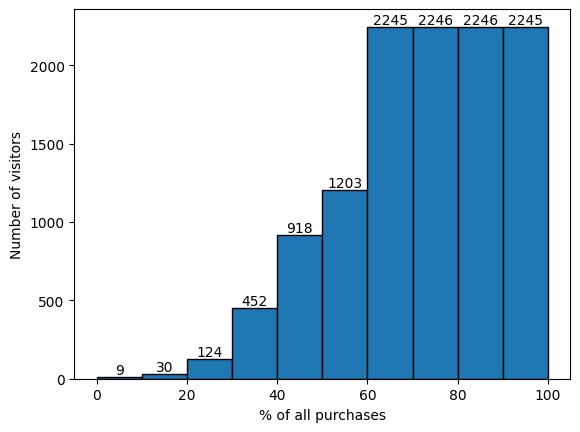

In [156]:
bin_edges = range(0, int(customer_orders['cum_sum'].max()) + 10, 10)
counts, bins, patches = plt.hist(customer_orders['cum_sum'], bins=bin_edges, edgecolor='black')
for count, bin_edge in zip(counts, bins[:-1]):  
    if count > 0: 
        x_position = (bin_edge + (bin_edge + 10)) / 2  
        plt.text(x_position, count, str(int(count)), ha='center', va='bottom')

plt.xlabel('% of all purchases')
plt.ylabel('Number of visitors')

plt.show()

In [271]:
categories = item_properties[item_properties['property']=='categoryid'][['itemid', 'value']]
categories = categories.drop_duplicates()
categories.rename(columns={'value':'categoryid'}, inplace=True)
categories['categoryid'] = categories['categoryid'].astype(int)

In [272]:
events = events.merge(categories, on='itemid', how='left')

In [273]:
def get_category_path(category_tree_df, category_id):
  
    path = []
    current_id = category_id
    
    # Prevent infinite loops in case of circular references
    max_depth = 100  
    depth = 0
    
    while current_id is not None and depth < max_depth:
        path.append(current_id)
        # Find the parent of current category
        parent_row = category_tree_df[category_tree_df['categoryid'] == current_id]
        
        if parent_row.empty:
            break
            
        current_id = parent_row['parentid'].iloc[0]
        # If we've reached root (parent_id is None or 0)
        if pd.isna(current_id) or current_id == 0:
            break
            
        depth += 1
    
    return path

def merge_with_category_paths(main_df, category_tree_df, category_column='categoryid'):

    result_df = main_df.copy()
    
    paths = {}
    unique_categories = main_df[category_column].unique()
    
    for cat_id in unique_categories:
        if pd.notna(cat_id):  # Skip if category_id is NaN
            paths[cat_id] = get_category_path(category_tree_df, cat_id)
    
    max_path_length = max(len(path) for path in paths.values())
    
    for level in range(1,max_path_length):
        result_df[f'parent_level_{level}'] = np.nan
    
    # Fill in path levels
    for idx, row in result_df.iterrows():
        cat_id = row[category_column]
        if pd.notna(cat_id) and cat_id in paths:
            path = paths[cat_id]
            for level, path_cat_id in enumerate(path):
                if level==0:
                    continue
                result_df.at[idx, f'parent_level_{level}'] = int(path_cat_id)

    
    return result_df

In [274]:
events = merge_with_category_paths(events, category_tree)

In [275]:
for i in range(1, 6):
    if i == 1:
        events.loc[events[f'parent_level_{i}'].isna(), f'parent_level_{i}'] = events['categoryid']
    else:
        events.loc[events[f'parent_level_{i}'].isna(), f'parent_level_{i}'] = events[f'parent_level_{i-1}']
        # events[f'parent_level_{i}'] = events[f'parent_level_{i}'].where(events[f'parent_level_{i}'].notna(), events[f'parent_level_{i-1}'])

In [276]:
events

,timestamp,visitorid,event,itemid,categoryid,parent_level_1,parent_level_2,parent_level_3,parent_level_4,parent_level_5
0,2015-06-01 22:02:12.117,257597,view,355908,1173.0,805.0,384.0,140.0,140.0,140.0
1,2015-06-01 22:50:14.164,992329,view,248676,1231.0,901.0,679.0,679.0,679.0,679.0
2,2015-06-01 22:13:19.827,111016,view,318965,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-06-01 22:12:35.914,483717,view,253185,914.0,226.0,107.0,1532.0,1532.0,1532.0
4,2015-06-01 22:02:17.106,951259,view,367447,1613.0,250.0,250.0,250.0,250.0,250.0
...,...,...,...,...,...,...,...,...,...,...
2964521,2015-07-31 20:13:05.939,591435,view,261427,1623.0,1066.0,293.0,1532.0,1532.0,1532.0
2964522,2015-07-31 20:30:13.142,762376,view,115946,1616.0,827.0,920.0,140.0,140.0,140.0
2964523,2015-07-31 19:57:00.527,1251746,view,78144,969.0,1141.0,55.0,1600.0,1600.0,1600.0
2964524,2015-07-31 20:08:50.703,1184451,view,283392,1589.0,1426.0,1482.0,1482.0,1482.0,1482.0


In [277]:
main_categories = events['parent_level_5'].unique()
main_categories = [int(i) for i in main_categories if ~np.isnan(i) ]
main_categories

[140,
 679,
 1532,
 250,
 1600,
 1482,
 1579,
 395,
 378,
 653,
 1224,
 1490,
 1394,
 791,
 1452,
 1698,
 1057,
 803,
 431,
 859,
 755,
 659,
 1692]

In [278]:
category_item = events.groupby(['parent_level_5'])['itemid'].apply(lambda x: len(set(x))).reset_index(name='num_items')
category_pivot = events.pivot_table(index='parent_level_5', columns='event', aggfunc='size', fill_value=0).reset_index()
category_pivot = category_pivot.merge(category_item, on='parent_level_5', how='left')
category_pivot

,parent_level_5,addtocart,transaction,view,num_items
0,140.0,21651,7827,714867,37121
1,250.0,2389,536,126307,12294
2,378.0,405,150,33626,4909
3,395.0,5028,1734,214115,14462
4,431.0,1,1,13374,3805
5,653.0,4627,1499,192860,10471
6,659.0,1,1,15,4
7,679.0,3056,849,96514,5897
8,755.0,0,0,838,213
9,791.0,1231,305,34079,12142


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


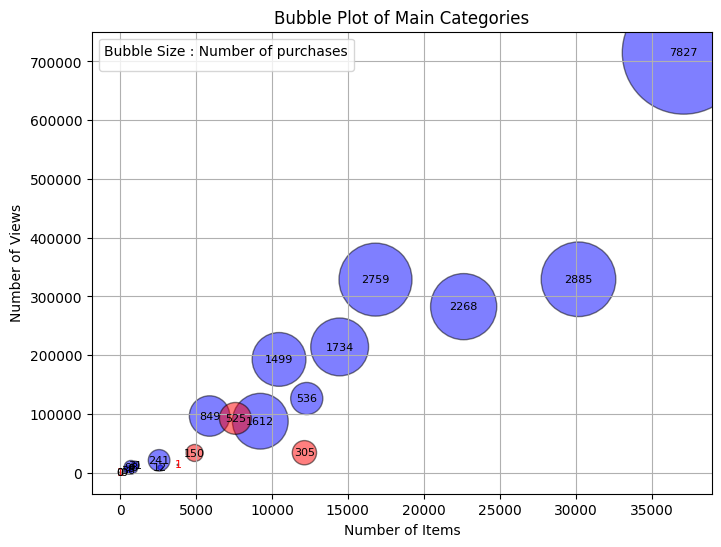

In [280]:
category_pivot['color'] = category_pivot['transaction'].apply(lambda x: 'red' if x in [1, 150, 305, 525] else 'blue')
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    category_pivot['num_items'],  # X-axis: number of items
    category_pivot['view'],      # Y-axis: views
    s=category_pivot['transaction'] ,  # Bubble size: purchase (scaled for visibility)
    alpha=0.5,                   # Transparency for better visibility
    color=category_pivot['color'],                # Bubble color
    edgecolor='black'            
)

for x, y, size in zip(category_pivot['num_items'], category_pivot['view'], category_pivot['transaction']):
    if size==1:
        color='red'
    else:
        color='black'
    plt.text(
        x, y,                    
        str(size),               
        fontsize=8,              
        ha='center',             
        va='center',           
        color=color           
    )

plt.xlabel('Number of Items')
plt.ylabel('Number of Views')
plt.title('Bubble Plot of Main Categories')
plt.grid(True)
plt.legend(
    title='Bubble Size : Number of purchases')
# Show plot
plt.show()

In [282]:
item_availibility = item_properties[item_properties['property']=="available"]
item_availibility=item_availibility.merge(events[['itemid','parent_level_5']].drop_duplicates(), how='left', on='itemid')
item_availibility = item_availibility.drop_duplicates()
item_availibility

,timestamp,itemid,property,value,parent_level_5
0,2015-07-04 20:00:00,285026,available,0,1224.0
1,2015-07-18 20:00:00,186518,available,0,1482.0
2,2015-06-06 20:00:00,423682,available,0,395.0
3,2015-06-13 20:00:00,316253,available,1,NaN
4,2015-07-18 20:00:00,430459,available,0,653.0
...,...,...,...,...,...
1550146,2015-08-29 20:00:00,229797,available,0,791.0
1550147,2015-08-01 20:00:00,225378,available,1,378.0
1550148,2015-05-30 20:00:00,356167,available,0,1490.0
1550149,2015-08-08 20:00:00,200211,available,0,1224.0


In [283]:
item_availibility['value'] = item_availibility['value'].astype('int')
item_availibility['timestamp'] = item_availibility['timestamp'].dt.date
item_availibility = item_availibility.sort_values(by=['itemid','timestamp'])

In [284]:
def calculate_weeks(item_data):
    timestamps = item_data['timestamp'].tolist()
    values = item_data['value'].tolist()

    if len(values)==1:
        if values[0]==1:
            return 0
        else:
            return 19
    
    total_weeks = 0
    last_zero_index = None

    for i, val in enumerate(values):
       
        if val == 0:
            if last_zero_index is None:
                last_zero_index = i

        else:
            if last_zero_index is not None:
                gap = (timestamps[i] - timestamps[last_zero_index]).days / 7
                total_weeks += gap
            last_zero_index = None
    
    if last_zero_index is not None:
        gap_to_target = (pd.to_datetime('2015-09-12').date() - timestamps[last_zero_index]).days / 7
        total_weeks += gap_to_target+1

    return total_weeks

result = item_availibility.groupby('itemid').apply(calculate_weeks).reset_index()
result.columns = ['itemid', 'unavailable_weeks']
result

,itemid,unavailable_weeks
0,0,19.0
1,1,18.0
2,2,19.0
3,3,19.0
4,4,19.0
...,...,...
417048,466862,19.0
417049,466863,19.0
417050,466864,5.0
417051,466865,19.0


In [285]:
item_pivot = events.pivot_table(index='itemid', columns='event', aggfunc='size', fill_value=0).reset_index()
item_pivot=item_pivot.merge(result, on='itemid', how='left')

In [286]:
item_pivot = item_pivot.merge(events[['itemid','parent_level_5']].drop_duplicates(), on = 'itemid',how='left')
item_pivot

,itemid,addtocart,transaction,view,unavailable_weeks,parent_level_5
0,3,0,0,2,19.0,1532.0
1,4,0,0,3,19.0,1532.0
2,6,0,0,29,12.0,1600.0
3,9,0,0,2,NaN,NaN
4,15,3,1,18,10.0,653.0
...,...,...,...,...,...,...
245800,466861,5,1,89,6.0,140.0
245801,466862,0,0,4,19.0,1532.0
245802,466863,0,0,1,19.0,1490.0
245803,466864,2,0,89,5.0,140.0


In [287]:
result = item_pivot.groupby('parent_level_5').agg({'itemid': 'size', 'addtocart':'sum', 'transaction':'sum', 'view':'sum','unavailable_weeks':[lambda x:sum(x>18),'mean']})

In [288]:
result

itemid addtocart transaction    view unavailable_weeks  \
                 size       sum         sum     sum        <lambda_0>   
parent_level_5                                                          
140.0           37121     21817        7887  720035             23061   
250.0           12294      4873        1093  253398              7209   
378.0            4909       425         158   34060              4193   
395.0           14462      5654        1895  259319             10003   
431.0            3805         2           1   13468              3785   
653.0           10471      4911        1598  199788              5230   
659.0               4         2           2      19                 1   
679.0            5897      4714        1151  159137              2933   
755.0             213         0           0     838               213   
791.0           12142      1231         305   34094              3153   
803.0             508       282          88   11240               165   
859.0             718       320          98    9209               387   
1057.0              5        14           0     380                 0   
1224.0           9236      4141        1622   88513               808   
1394.0            734         0           0    7704               734   
1452.0           1008       370          94   37416               405   
1482.0          22628      9513        2333  290463             12836   
1490.0           7593      2160         560   97233              4036   
1532.0          30191      8690        2993  350775             21313   
1579.0           2655        70          20   10211              2467   
1600.0          16823      9725        2789  330658              9881   
1692.0              2         0           0      76                 0   
1698.0           2571      1045         332   26651              1673   

                           
                     mean  
parent_level_5             
140.0           14.071577  
250.0           16.275826  
378.0           17.558973  
395.0           15.689600  
431.0           18.924573  
653.0           12.746156  
659.0           16.500000  
679.0           14.778192  
755.0           19.000000  
791.0            8.323999  
803.0           13.895669  
859.0           13.413649  
1057.0           5.200000  
1224.0           4.764075  
1394.0          19.000000  
1452.0          14.482143  
1482.0          13.323891  
1490.0          13.776636  
1532.0          15.793349  
1579.0          18.238418  
1600.0          13.999346  
1692.0           3.500000  
1698.0          15.990665

In [ ]:
top_users = set(customer_orders[customer_orders['cum_sum']<=20]['visitorid'])
user_pivot = events.pivot_table(index='visitorid', columns='event', aggfunc='size', fill_value=0).reset_index()

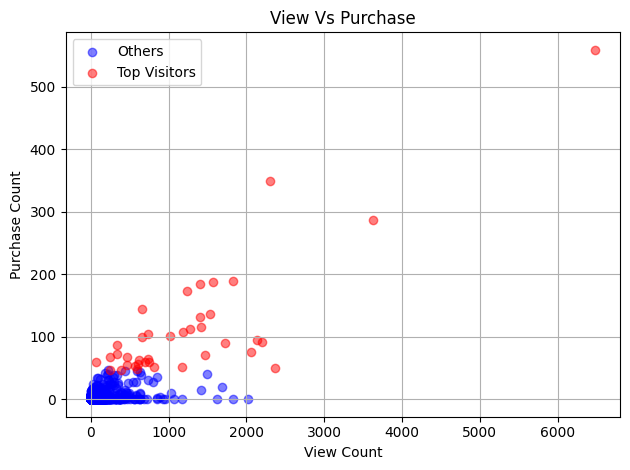

In [269]:
user_pivot['color'] = user_pivot['visitorid'].apply(lambda x: 'red' if x in top_users else 'blue')


# Scatter plot with custom colors
for color, group in user_pivot.groupby('color'):
    plt.scatter(group['view'], group['transaction'], color=color, alpha=0.5, label='Top Visitors' if color=='red' else "Others")

# Adding labels and titles
plt.xlabel('View Count')
plt.ylabel('Purchase Count')
plt.title('View Vs Purchase')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

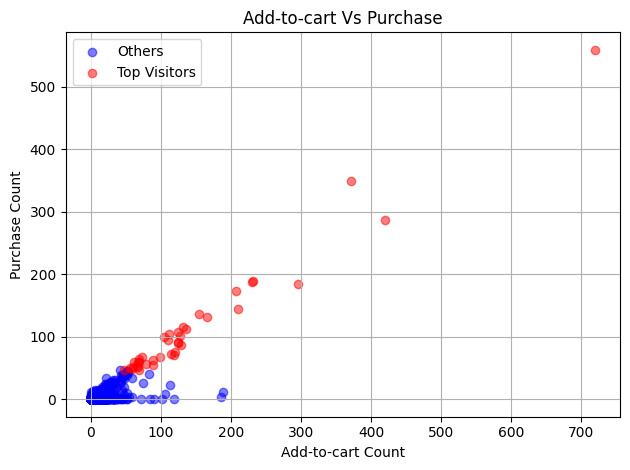

In [279]:
for color, group in user_pivot.groupby('color'):
    plt.scatter(group['addtocart'], group['transaction'], color=color, alpha=0.5, label='Top Visitors' if color=='red' else "Others")

# Adding labels and titles
plt.xlabel('Add-to-cart Count')
plt.ylabel('Purchase Count')
plt.title('Add-to-cart Vs Purchase')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [13]:
item_orders = purchases['itemid'].value_counts(normalize=True)*100
item_orders = pd.DataFrame({'itemid':item_orders.index, 'num_orders':item_orders.values})
item_orders['cum_sum'] = item_orders['num_orders'].cumsum()
item_orders

,itemid,num_orders,cum_sum
0,461686,0.592243,0.592243
1,119736,0.431937,1.024180
2,213834,0.409672,1.433851
3,312728,0.204836,1.638687
4,7943,0.204836,1.843523
...,...,...,...
12020,411039,0.004453,99.982188
12021,233427,0.004453,99.986641
12022,78388,0.004453,99.991094
12023,311292,0.004453,99.995547


Text(0, 0.5, 'Number of items')

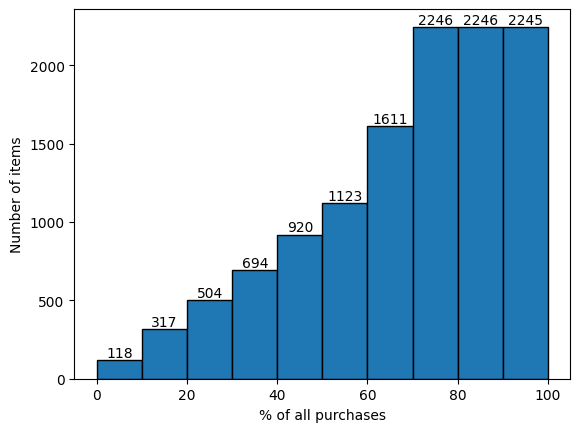

In [160]:
bin_edges = range(0, int(item_orders['cum_sum'].max()) + 10, 10)
counts, bins, patches = plt.hist(item_orders['cum_sum'], bins=bin_edges, edgecolor='black')
for count, bin_edge in zip(counts, bins[:-1]):  
    if count > 0: 
        x_position = (bin_edge + (bin_edge + 10)) / 2  
        plt.text(x_position, count, str(int(count)), ha='center', va='bottom')

plt.xlabel('% of all purchases')
plt.ylabel('Number of items')

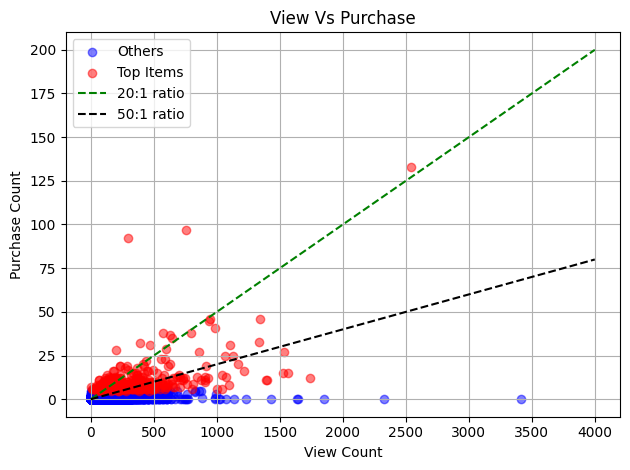

In [14]:
top_items = set(item_orders[item_orders['cum_sum']<=20]['itemid'])
item_pivot = events.pivot_table(index='itemid', columns='event', aggfunc='size', fill_value=0).reset_index()
item_pivot['color'] = item_pivot['itemid'].apply(lambda x: 'red' if x in top_items else 'blue')

for color, group in item_pivot.groupby('color'):
    plt.scatter(group['view'], group['transaction'], color=color, alpha=0.5, label='Top Items' if color=='red' else "Others")

plt.plot(range(4000), [0.05* i for i in range(4000)], linestyle='--',color='green',label="20:1 ratio")
plt.plot(range(4000), [0.02* i for i in range(4000)], linestyle='--',color='black',label="50:1 ratio")

# Adding labels and titles
plt.xlabel('View Count')
plt.ylabel('Purchase Count')
plt.title('View Vs Purchase')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

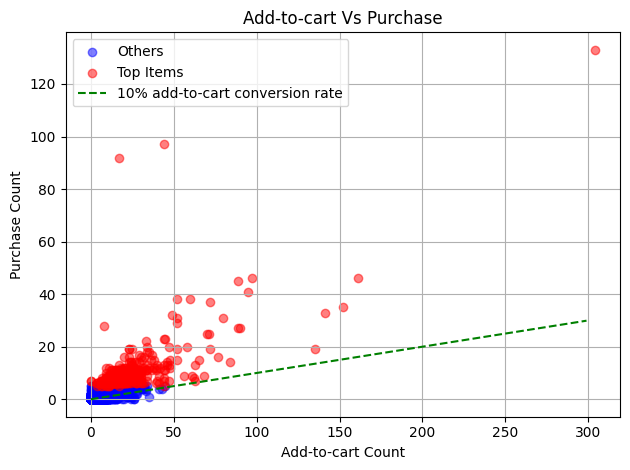

In [289]:
for color, group in item_pivot.groupby('color'):
    plt.scatter(group['addtocart'], group['transaction'], color=color, alpha=0.5, label='Top Items' if color=='red' else "Others")

plt.plot(range(300),[0.1*i for i in range(300)],linestyle='--', color='green', label='10% add-to-cart conversion rate')

# Adding labels and titles
plt.xlabel('Add-to-cart Count')
plt.ylabel('Purchase Count')
plt.title('Add-to-cart Vs Purchase')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [302]:
events = events.sort_values(by=['visitorid', 'timestamp'])
session_timeout = pd.Timedelta('30 minutes')
events['session_id'] = (events.groupby('visitorid')['timestamp'].diff() > session_timeout).cumsum()
session_time = events.groupby(['visitorid', 'session_id'])['timestamp'].agg(['min', 'max'])
session_time['time_spent'] = (session_time['max'] - session_time['min']).dt.total_seconds() / 60
sessions_per_user = session_time.groupby('visitorid').size()
total_time_spent_per_user = session_time.groupby('visitorid')['time_spent'].sum()
average_time_per_session_per_user = total_time_spent_per_user/ sessions_per_user

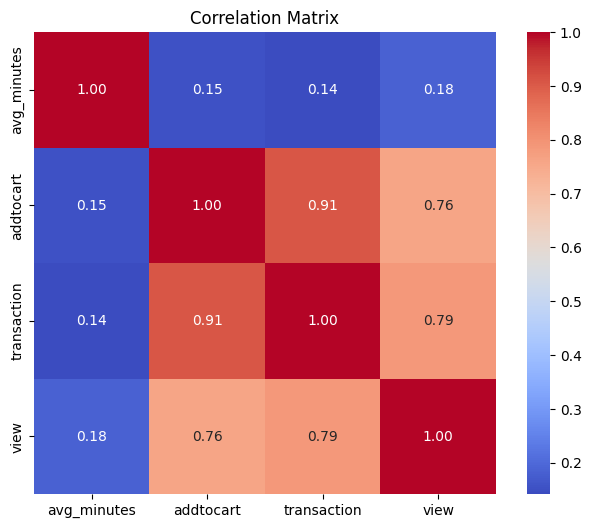

In [303]:
avg_time_user = pd.DataFrame({'visitorid':average_time_per_session_per_user.index, 'avg_minutes': average_time_per_session_per_user.values})
avg_time_user = avg_time_user[avg_time_user['avg_minutes']!=0]
avg_time_user = avg_time_user.merge(user_pivot, on='visitorid')
correlation_matrix = avg_time_user [['avg_minutes','addtocart','transaction','view']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

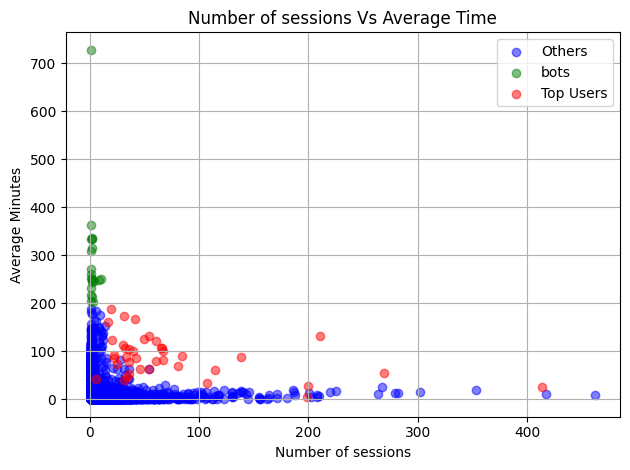

In [329]:
potential_bots = set(avg_time_user[avg_time_user['avg_minutes']>200]['visitorid'])
session_count = pd.DataFrame({'visitorid':sessions_per_user.index, 'num_sessions': sessions_per_user.values})
avg_time_user = avg_time_user.merge(session_count,on='visitorid')
avg_time_user['color'] = avg_time_user['visitorid'].apply(
    lambda x: 'red' if x in top_users else ('green' if x in potential_bots else 'blue')
)

for color, group in avg_time_user.groupby('color'):
    plt.scatter(group['num_sessions'], group['avg_minutes'], color=color, alpha=0.5, label='Top Users' if color=='red' else ('bots' if color=='green' else "Others"))


# Adding labels and titles
plt.ylabel('Average Minutes')
plt.xlabel('Number of sessions')
plt.title('Number of sessions Vs Average Time')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


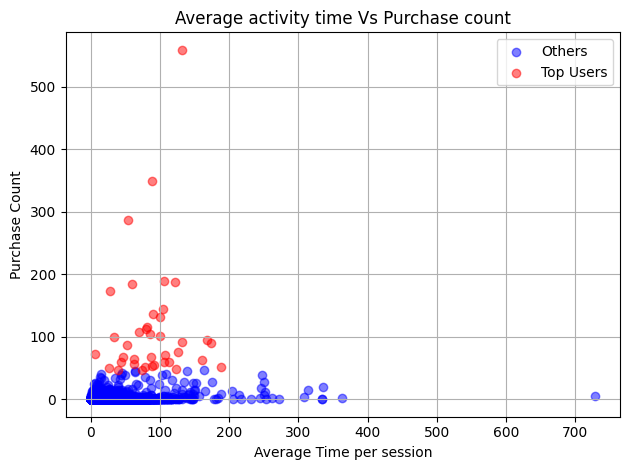

In [321]:

avg_time_user['color'] = avg_time_user['visitorid'].apply(lambda x: 'red' if x in top_users else 'blue')

for color, group in avg_time_user.groupby('color'):
    plt.scatter(group['avg_minutes'], group['transaction'], color=color, alpha=0.5, label='Top Users' if color=='red' else "Others")


# Adding labels and titles
plt.xlabel('Average Time per session')
plt.ylabel('Purchase Count')
plt.title('Average activity time Vs Purchase count')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [335]:
returning_user = purchases['visitorid'].value_counts()
returning_user = pd.DataFrame({'visitorid':returning_user.index, 'num_purchases':returning_user.values})
returning_user[returning_user['num_purchases']>1].shape[0]/returning_user.shape[0]

0.21981397730181756

In [290]:
events['date'] = events['timestamp'].dt.date
events['month'] = events['timestamp'].dt.month
events['dayofweek'] = events['timestamp'].dt.day_name()
events['hourofday'] = events['timestamp'].dt.hour
events['week'] = events['timestamp'].dt.isocalendar().week

In [36]:
user_visit_days = events.groupby('visitorid')['date'].unique()

user_visit_days_count = user_visit_days.apply(len)

def avg_days_between_visits(dates):
    sorted_dates = sorted(dates)
    date_differences = [ (sorted_dates[i] - sorted_dates[i-1]).days for i in range(1, len(sorted_dates))]
    
    if date_differences:
        return sum(date_differences) / len(date_differences)
    else:
        return 0

avg_days = user_visit_days.apply(avg_days_between_visits)
result = pd.DataFrame({
    'num_days_visited': user_visit_days_count,
    'avg_days_between_visits': avg_days
})

In [ ]:
result = result.reset_index()
result = result[result['num_days_visited']>1]

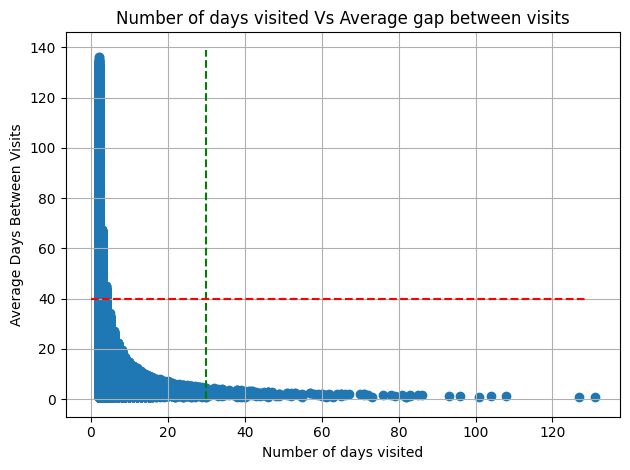

In [24]:
# plt.figure(figsize=(10, 6))
plt.scatter(result['num_days_visited'], result['avg_days_between_visits'])
plt.plot([30]*140,range(140),linestyle='--', color='green')
plt.plot(range(130),[40]*130,linestyle='--', color='red')
plt.ylabel('Average Days Between Visits')
plt.xlabel('Number of days visited')
plt.title('Number of days visited Vs Average gap between visits')
plt.grid(True)

plt.tight_layout()

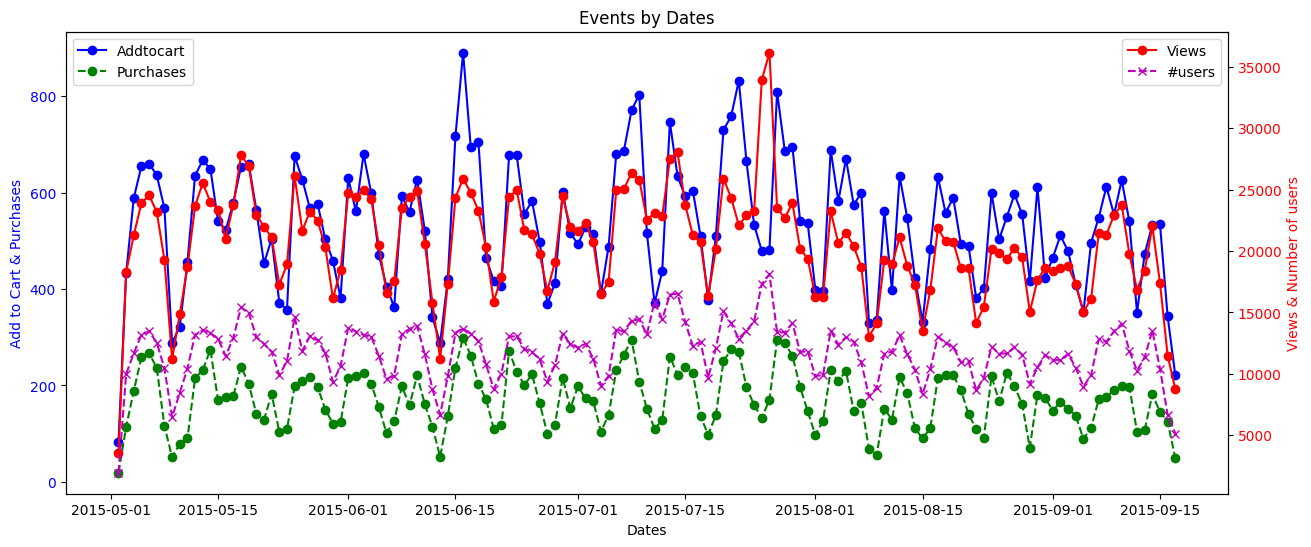

In [306]:
events_by_date = events.pivot_table(index='date', columns='event', aggfunc='size', fill_value=0).reset_index()
events_by_date=events_by_date.sort_values(by='date')
users_by_date = events.groupby(['date'])['visitorid'].apply(lambda x:len(set(x))).reset_index()
users_by_date = users_by_date.sort_values(by='date')

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(events_by_date['date'], events_by_date['addtocart'], marker='o', linestyle='-', color='b', label='Addtocart')
ax1.plot(events_by_date['date'], events_by_date['transaction'], marker='o', linestyle='--', color='g', label='Purchases')

ax1.set_xlabel('Dates')
ax1.set_ylabel('Add to Cart & Purchases', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Secondary y-axis plot
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(events_by_date['date'], events_by_date['view'], marker='o', linestyle='-', color='r', label='Views')
ax2.plot(users_by_date['date'], users_by_date['visitorid'], marker='x', linestyle='--', color='m', label='#users')
ax2.set_ylabel('Views & Number of users', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a legend for the secondary y-axis
ax2.legend(loc='upper right')

# Display the plot
plt.title("Events by Dates")
plt.show()

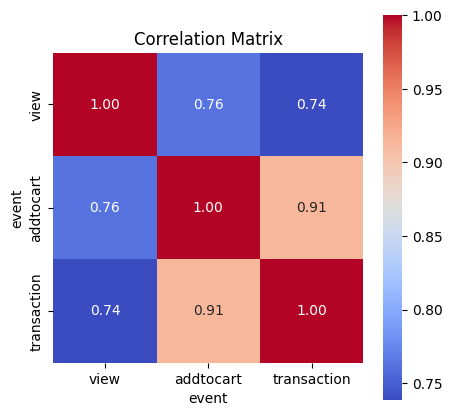

In [39]:
correlation_matrix = events_by_date[['view','addtocart','transaction']].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

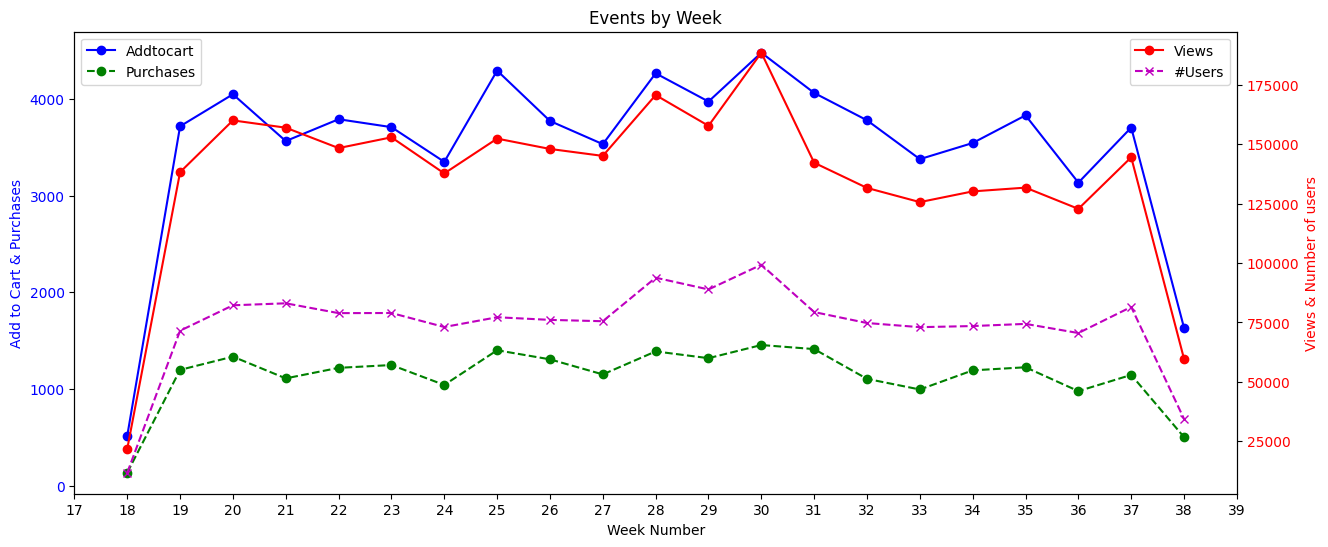

In [ ]:
events_by_week = events.pivot_table(index='week', columns='event', aggfunc='size', fill_value=0).reset_index()
events_by_week = events_by_week.sort_values(by='week')
users_by_week = events.groupby(['week'])['visitorid'].apply(lambda x:len(set(x))).reset_index()
users_by_week = users_by_week.sort_values(by='week')
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(events_by_week['week'], events_by_week['addtocart'], marker='o', linestyle='-', color='b', label='Addtocart')
ax1.plot(events_by_week['week'], events_by_week['transaction'], marker='o', linestyle='--', color='g', label='Purchases')

specific_x_ticks = range(17,40) 
plt.xticks(specific_x_ticks) 

ax1.set_xlabel('Week Number')
ax1.set_ylabel('Add to Cart & Purchases', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Secondary y-axis plot
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(events_by_week['week'], events_by_week['view'], marker='o', linestyle='-', color='r', label='Views')
ax2.plot(users_by_week['week'], users_by_week['visitorid'], marker='x', linestyle='--', color='m', label='#Users')
ax2.set_ylabel('Views & Number of users', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a legend for the secondary y-axis
ax2.legend(loc='upper right')

# Display the plot
plt.title("Events by Week")
plt.show()

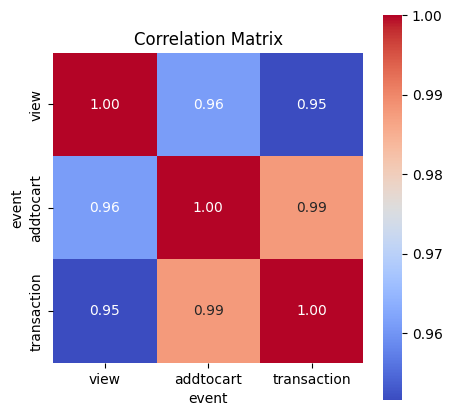

In [40]:
correlation_matrix = events_by_week[['view','addtocart','transaction']].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

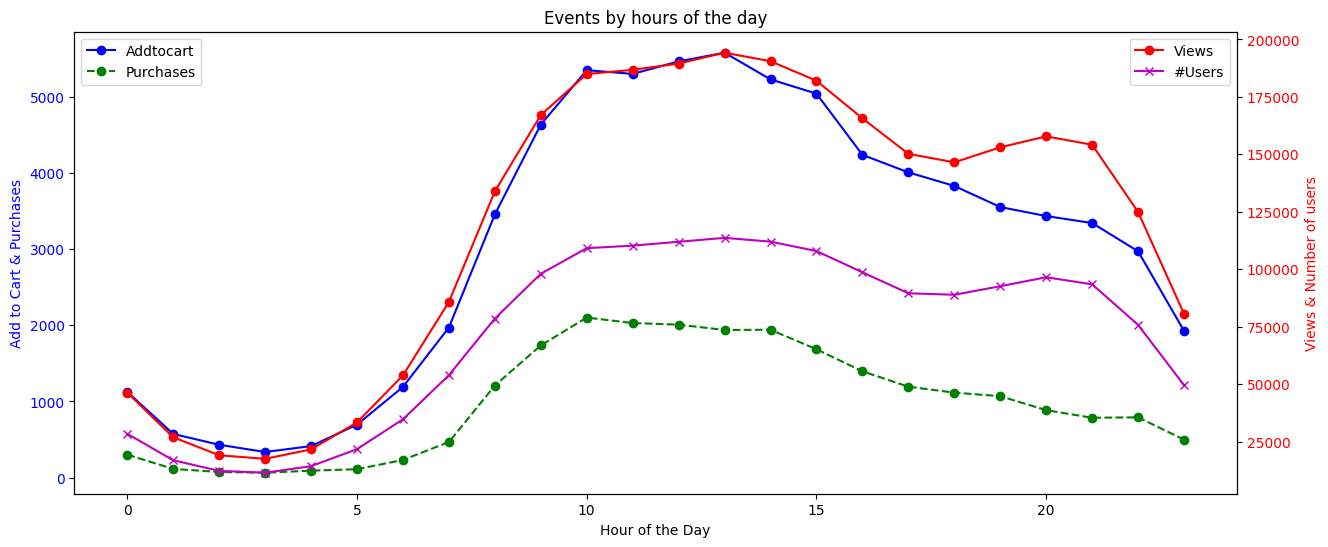

In [ ]:
events_by_hour = events.pivot_table(index='hourofday', columns='event', aggfunc='size', fill_value=0).reset_index()
events_by_hour=events_by_hour.sort_values(by='hourofday')

users_by_hour = events.groupby(['hourofday'])['visitorid'].apply(lambda x:len(set(x))).reset_index()
users_by_hour=users_by_hour.sort_values(by='hourofday')

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(events_by_hour['hourofday'], events_by_hour['addtocart'], marker='o', linestyle='-', color='b', label='Addtocart')
ax1.plot(events_by_hour['hourofday'], events_by_hour['transaction'], marker='o', linestyle='--', color='g', label='Purchases')

ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Add to Cart & Purchases', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Secondary y-axis plot
ax2 = ax1.twinx()  
ax2.plot(events_by_hour['hourofday'], events_by_hour['view'], marker='o', linestyle='-', color='r', label='Views')
ax2.plot(users_by_hour['hourofday'], users_by_hour['visitorid'], marker='x', linestyle='-', color='m', label='#Users')
ax2.set_ylabel('Views & Number of users', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax2.legend(loc='upper right')

plt.title("Events by hours of the day")
plt.show()

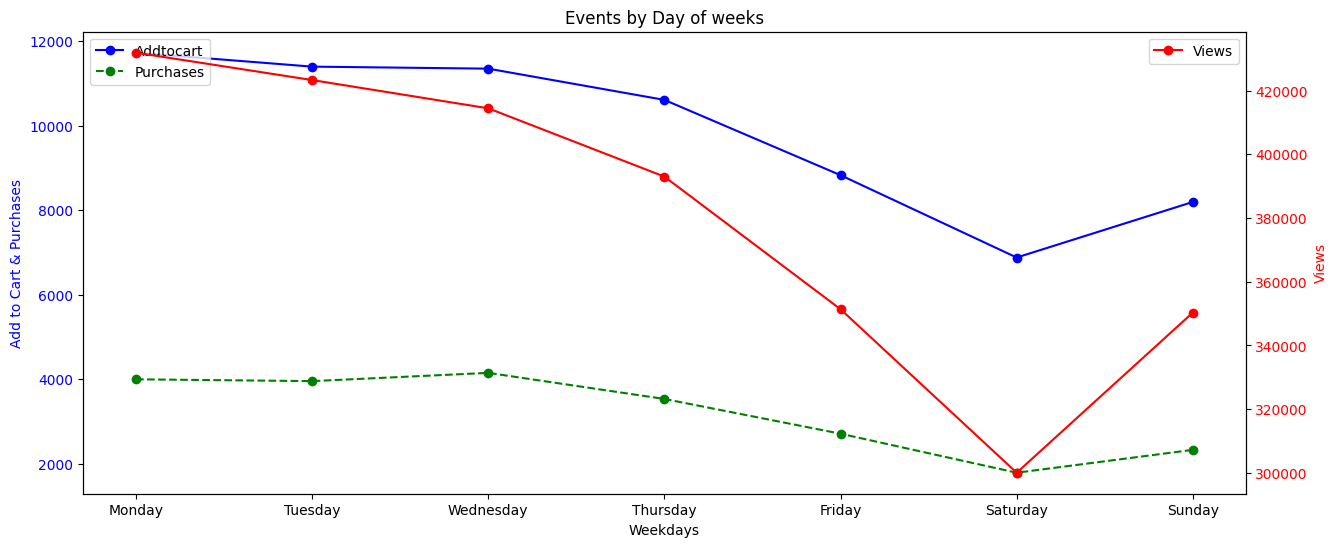

In [389]:
events_by_day = events.pivot_table(index='dayofweek', columns='event', aggfunc='size', fill_value=0).reset_index()
events_by_day['dayofweek'] = pd.Categorical(events_by_day['dayofweek'], categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
events_by_day=events_by_day.sort_values(by='dayofweek')
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(events_by_day['dayofweek'], events_by_day['addtocart'], marker='o', linestyle='-', color='b', label='Addtocart')
ax1.plot(events_by_day['dayofweek'], events_by_day['transaction'], marker='o', linestyle='--', color='g', label='Purchases')

ax1.set_xlabel('Weekdays')
ax1.set_ylabel('Add to Cart & Purchases', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Secondary y-axis plot
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(events_by_day['dayofweek'], events_by_day['view'], marker='o', linestyle='-', color='r', label='Views')
ax2.set_ylabel('Views', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a legend for the secondary y-axis
ax2.legend(loc='upper right')

# Display the plot
plt.title("Events by Day of weeks")
plt.show()

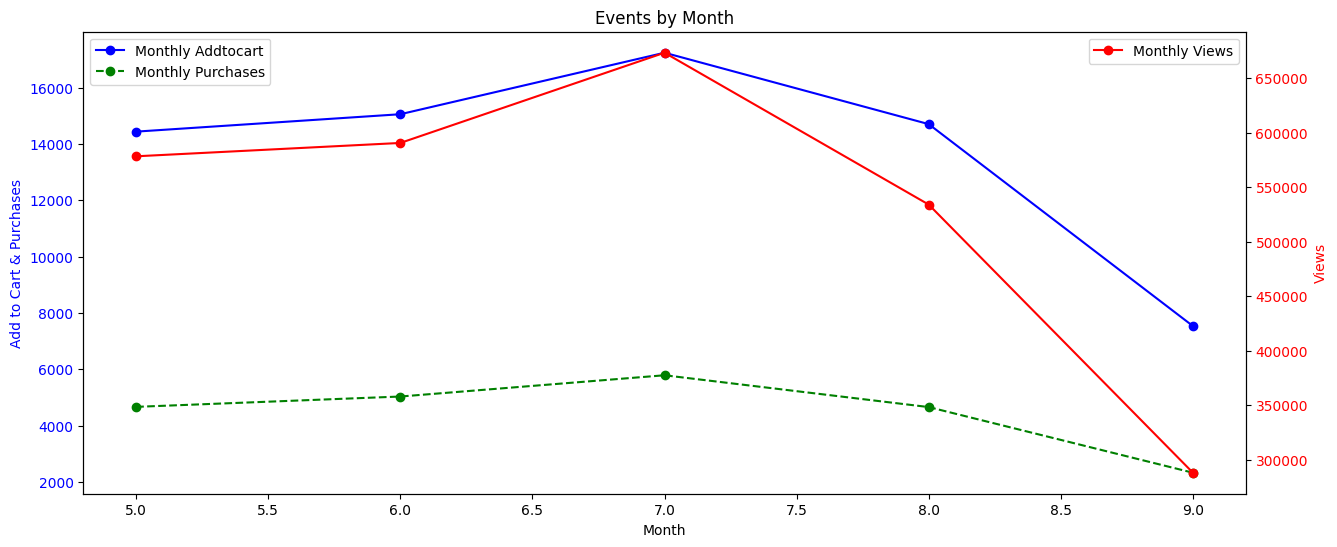

In [390]:
events_by_month = events.pivot_table(index='month', columns='event', aggfunc='size', fill_value=0).reset_index()
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(events_by_month['month'], events_by_month['addtocart'], marker='o', linestyle='-', color='b', label='Monthly Addtocart')
ax1.plot(events_by_month['month'], events_by_month['transaction'], marker='o', linestyle='--', color='g', label='Monthly Purchases')

ax1.set_xlabel('Month')
ax1.set_ylabel('Add to Cart & Purchases', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Secondary y-axis plot
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(events_by_month['month'], events_by_month['view'], marker='o', linestyle='-', color='r', label='Monthly Views')
ax2.set_ylabel('Views', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a legend for the secondary y-axis
ax2.legend(loc='upper right')

# Display the plot
plt.title("Events by Month")
plt.show()